In [ ]:
# Step 1: Connect to the Spark Livy service with %manage_spark (default endpoint Address: http://livy-0.livy-svc.spark.svc.cluster.local:8998)
# Step 2: Augment the image data in Spark cluster and save it to the shared volume $HOME/shared/data/train
# Step 3: Go back to getting_started.ipynb to continue on model training

In [1]:
%reload_ext sparkmagic.magics
%manage_spark

SSPI bindings not available, cannot use any SSPIProxy protocols: No module named 'spnego._sspi_raw.sspi'


MagicsControllerWidget(children=(Tab(children=(ManageSessionWidget(children=(HTML(value='<br/>'), HTML(value='…

In [2]:
%%spark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from warnings import filterwarnings
filterwarnings('ignore')

# Importing pyspark libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
%%spark
spark = SparkSession.builder.appName("Wind-turbine").getOrCreate()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
%%spark
from py4j.java_gateway import java_import
java_import(spark._sc._jvm, "org.apache.spark.sql.api.python.*")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
%%spark
spark_df = spark.read.csv('file:///mounts/shared-volume/shared/spark/T1.csv', header=True, inferSchema=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
%%spark
# Caching the dataset
spark_df.cache()

# Converting all the column names to lower case
spark_df = spark_df.toDF(*[c.lower() for c in spark_df.columns])

print('Show the first 5 rows')
print(spark_df.show(5))
print()
print('What are the variable data types?')
print(spark_df.printSchema())
print()
print('How many observations do we have?')
print(spark_df.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Show the first 5 rows
+----------------+-------------------+----------------+-----------------------------+--------------------+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (deg)|
+----------------+-------------------+----------------+-----------------------------+--------------------+
|01 01 2018 00:00|        380.0477905|      5.31133604|                  416.3289078|         259.9949036|
|01 01 2018 00:10|        453.7691956|     5.672166824|                  519.9175111|         268.6411133|
|01 01 2018 00:20|        306.3765869|     5.216036797|                  390.9000158|         272.5647888|
|01 01 2018 00:30|        419.6459045|     5.659674168|                   516.127569|         271.2580872|
|01 01 2018 00:40|        380.6506958|     5.577940941|                   491.702972|         265.6742859|
+----------------+-------------------+----------------+-----------------------------+--------------------+
only showing to

In [7]:
%%spark
# Extracting a substring from columns to create month and hour variables

from pyspark.sql.functions import substring
spark_df = spark_df.withColumn("month", substring("date/time", 4,2))
spark_df = spark_df.withColumn("hour", substring("date/time", 12,2))

# Converting string month and hour variables to integer
from pyspark.sql.types import IntegerType
spark_df = spark_df.withColumn('month', spark_df.month.cast(IntegerType()))
spark_df = spark_df.withColumn('hour', spark_df.hour.cast(IntegerType()))

print(spark_df.show(5))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+-------------------+----------------+-----------------------------+--------------------+-----+----+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (deg)|month|hour|
+----------------+-------------------+----------------+-----------------------------+--------------------+-----+----+
|01 01 2018 00:00|        380.0477905|      5.31133604|                  416.3289078|         259.9949036|    1|   0|
|01 01 2018 00:10|        453.7691956|     5.672166824|                  519.9175111|         268.6411133|    1|   0|
|01 01 2018 00:20|        306.3765869|     5.216036797|                  390.9000158|         272.5647888|    1|   0|
|01 01 2018 00:30|        419.6459045|     5.659674168|                   516.127569|         271.2580872|    1|   0|
|01 01 2018 00:40|        380.6506958|     5.577940941|                   491.702972|         265.6742859|    1|   0|
+----------------+-------------------+----------------+-

In [8]:
%%spark
pd.options.display.float_format = '{:.2f}'.format
spark_df.select('wind speed (m/s)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)').toPandas().describe()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       wind speed (m/s)  theoretical_power_curve (kwh)  lv activepower (kw)
count          50530.00                       50530.00             50530.00
mean               7.56                        1492.18              1307.68
std                4.23                        1368.02              1312.46
min                0.00                           0.00                -2.47
25%                4.20                         161.33                50.68
50%                7.10                        1063.78               825.84
75%               10.30                        2964.97              2482.51
max               25.21                        3600.00              3618.73

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

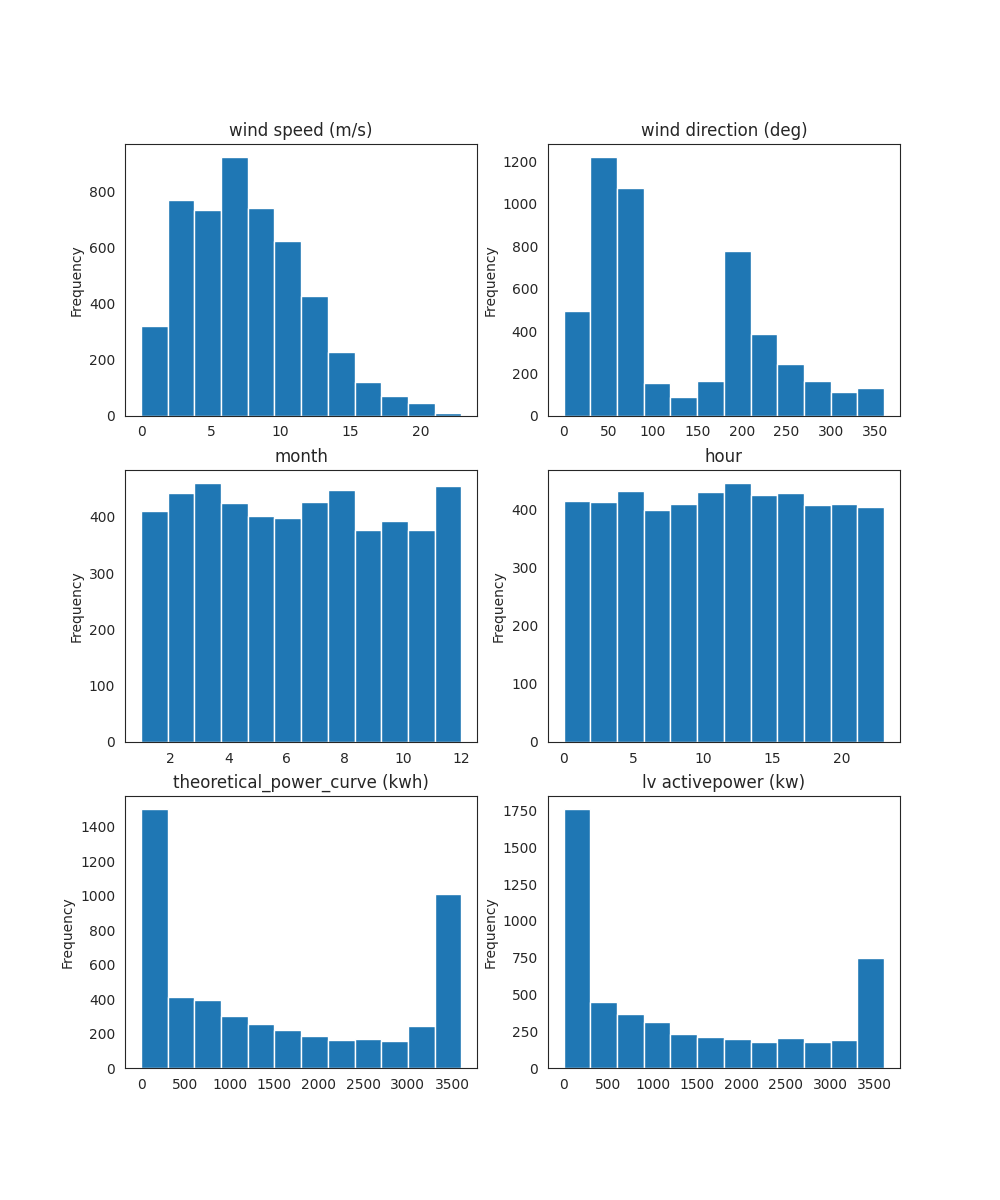

In [9]:
%%spark
# Taking a random sample from the big data
sample_df = spark_df.sample(withReplacement=False, fraction=0.1, seed=42).toPandas()

# Visualizing the distributions with the sample data
columns = ['wind speed (m/s)', 'wind direction (deg)', 'month', 'hour', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']
i=1
plt.figure(figsize=(10,12))
for each in columns:
    plt.subplot(3,2,i)
    sample_df[each].plot.hist(bins=12)
    plt.title(each)
    i += 1
%matplot plt


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

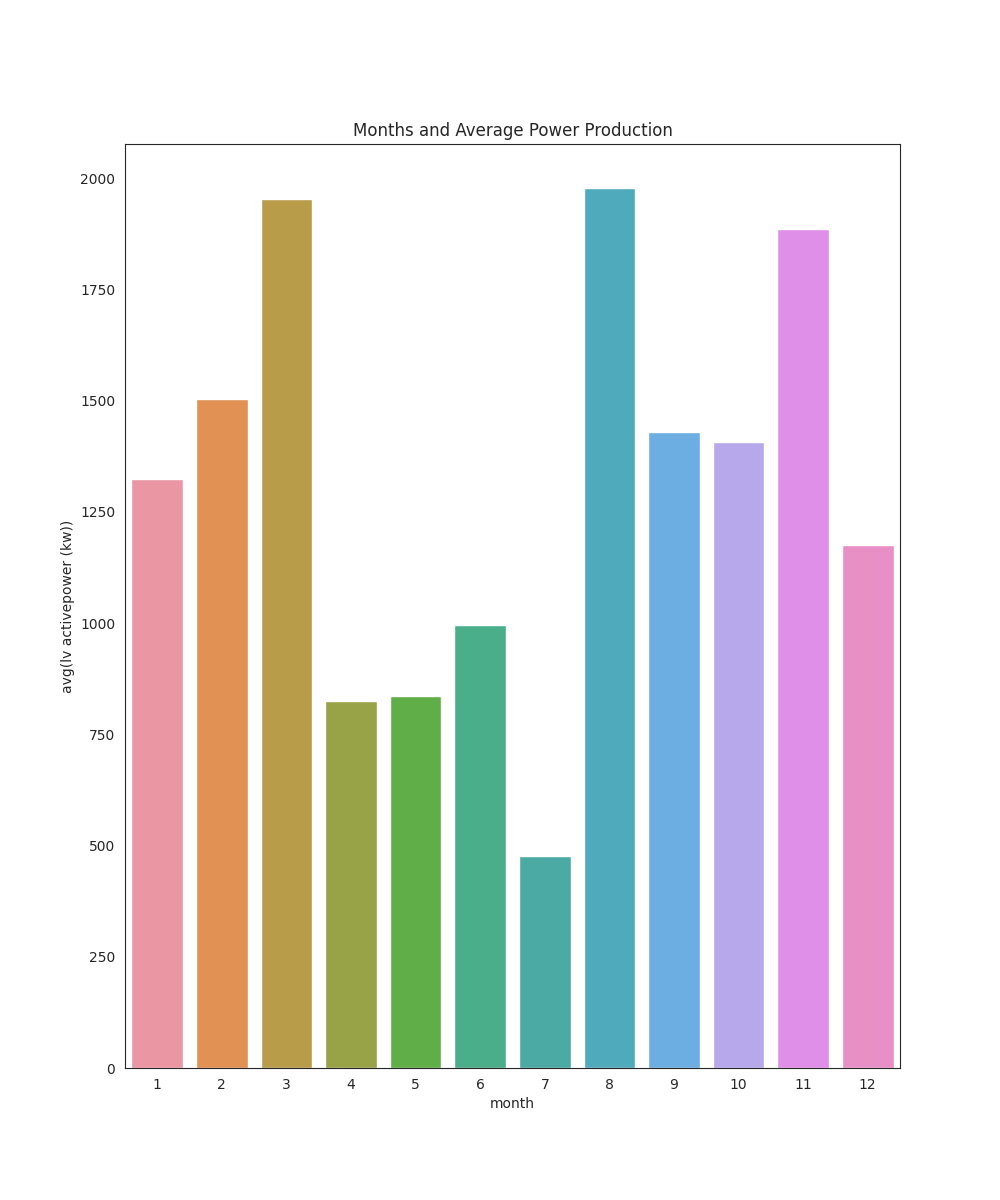

In [10]:
%%spark
plt.clf()

# Average power production by month
monthly = spark_df.groupby('month').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='month', y='avg(lv activepower (kw))', data=monthly)
plt.title('Months and Average Power Production');

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

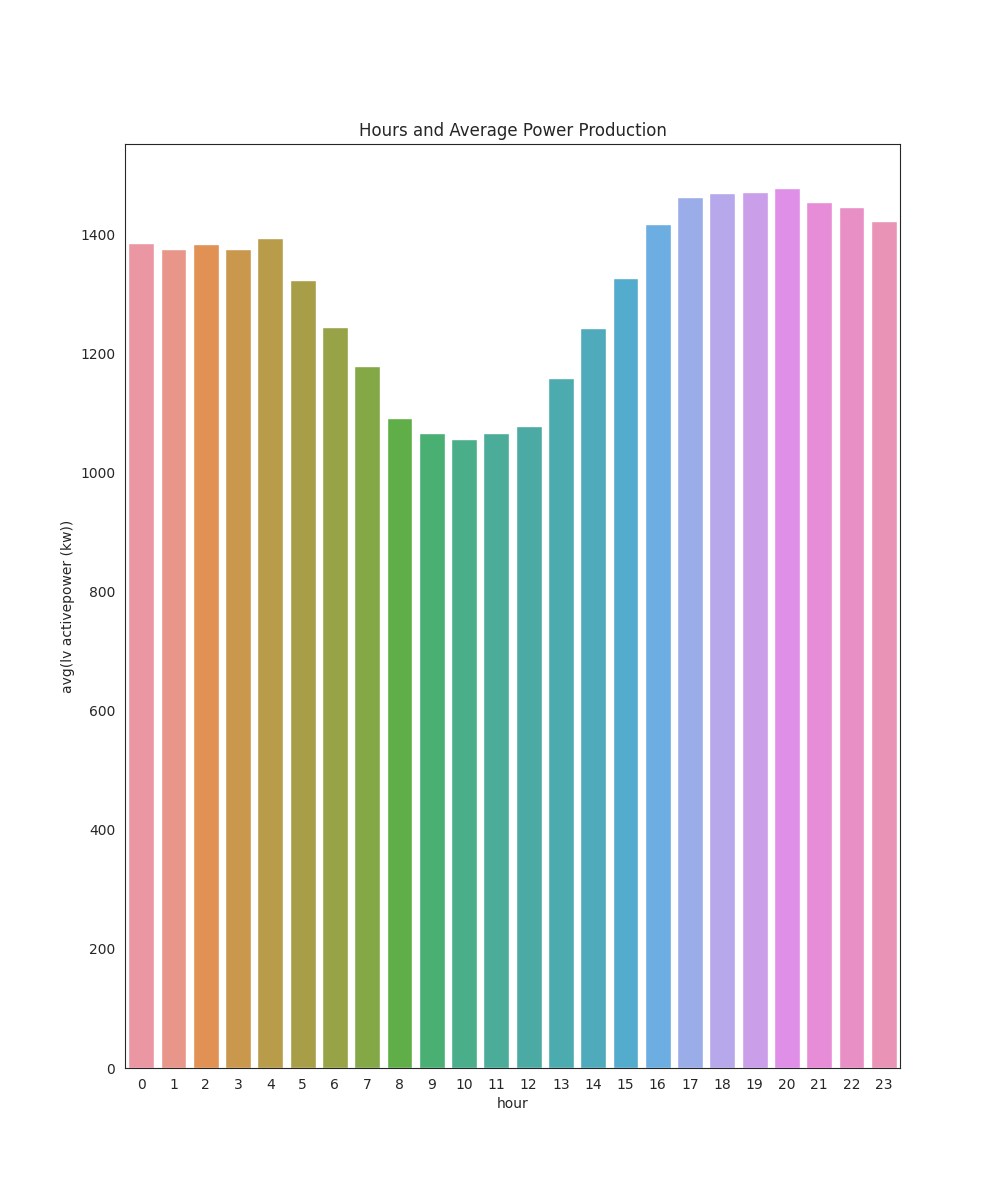

In [11]:
%%spark
plt.clf()

# Average power production by hour
hourly = spark_df.groupby('hour').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='hour', y='avg(lv activepower (kw))', data=hourly)
plt.title('Hours and Average Power Production');

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

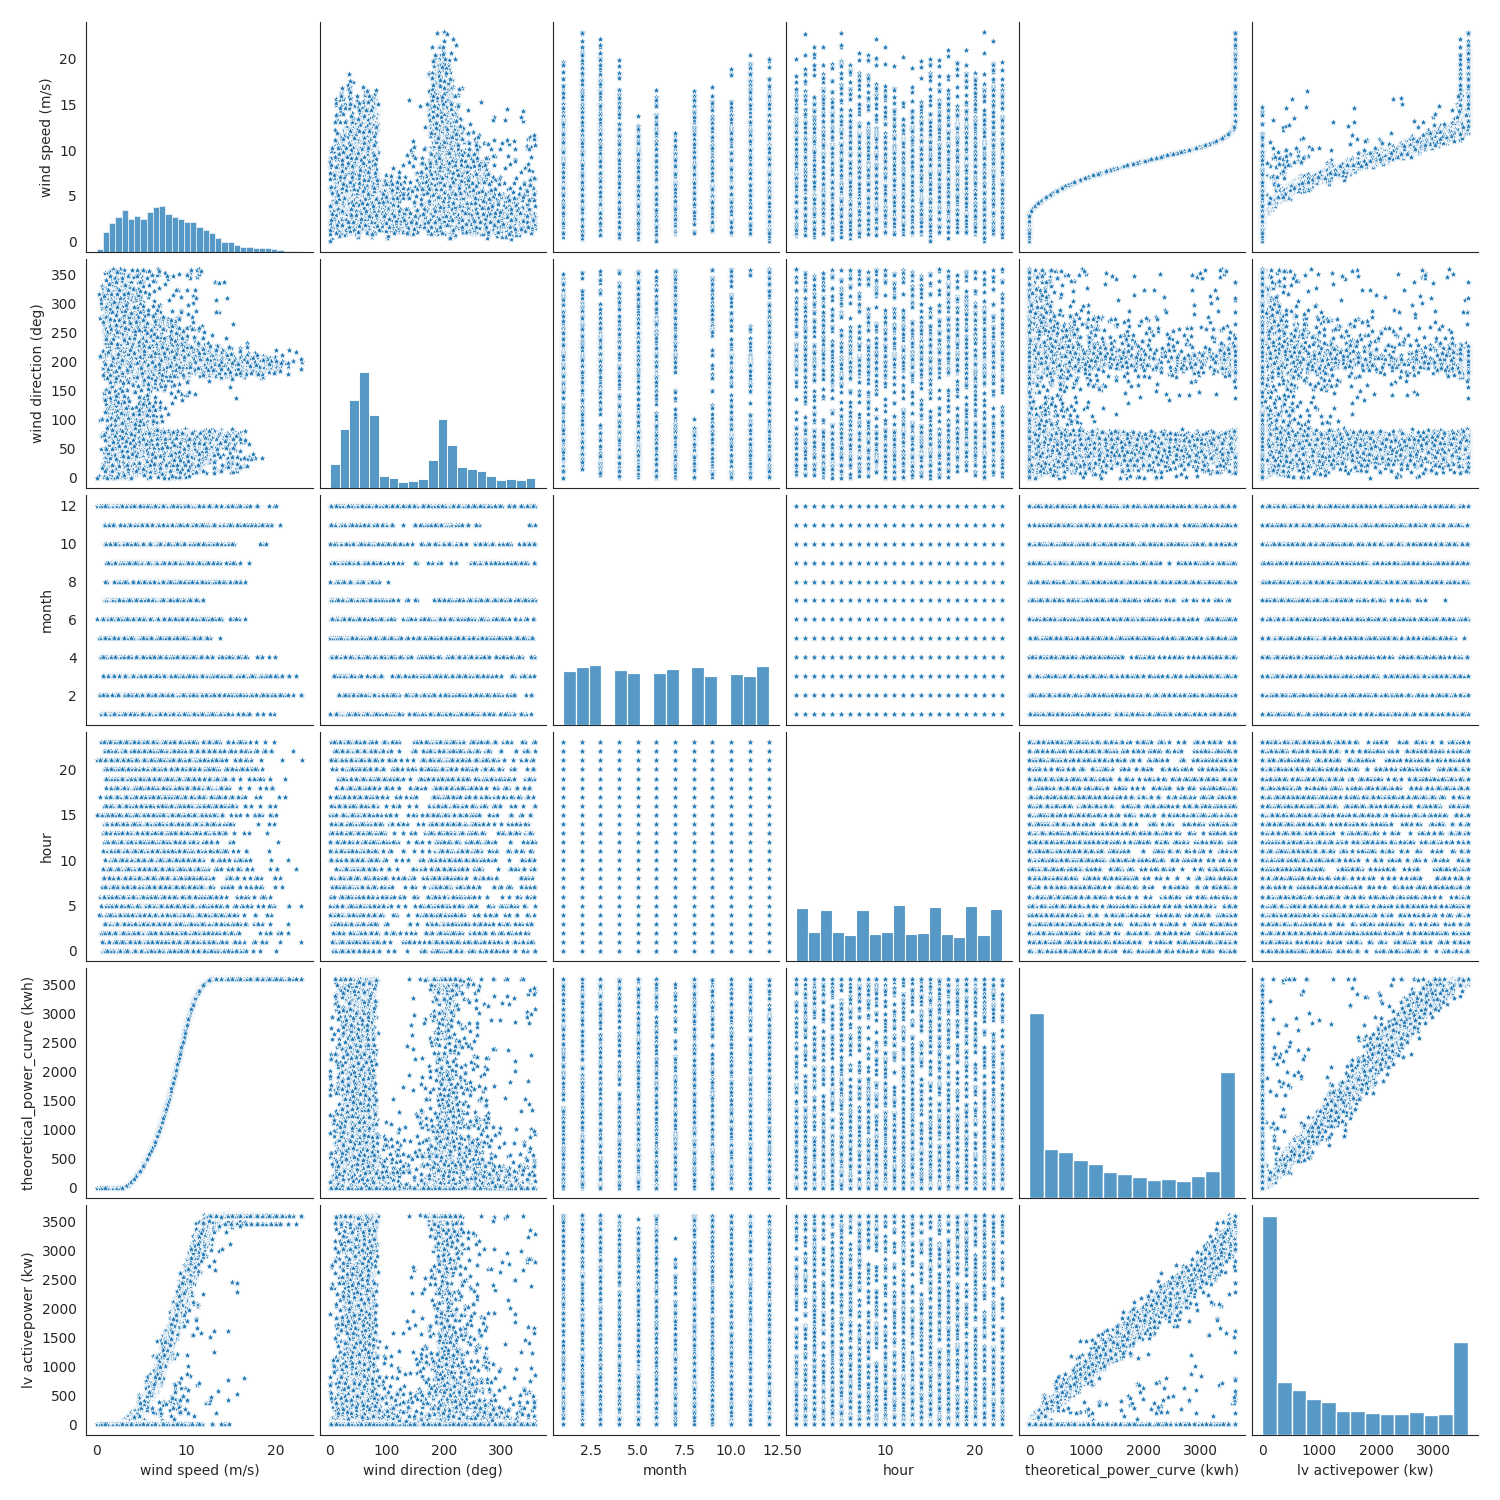

In [12]:
%%spark
pd.set_option('display.max_columns', None)
sample_df[columns].corr()
plt.clf()
sns.pairplot(sample_df[columns], markers='*');
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

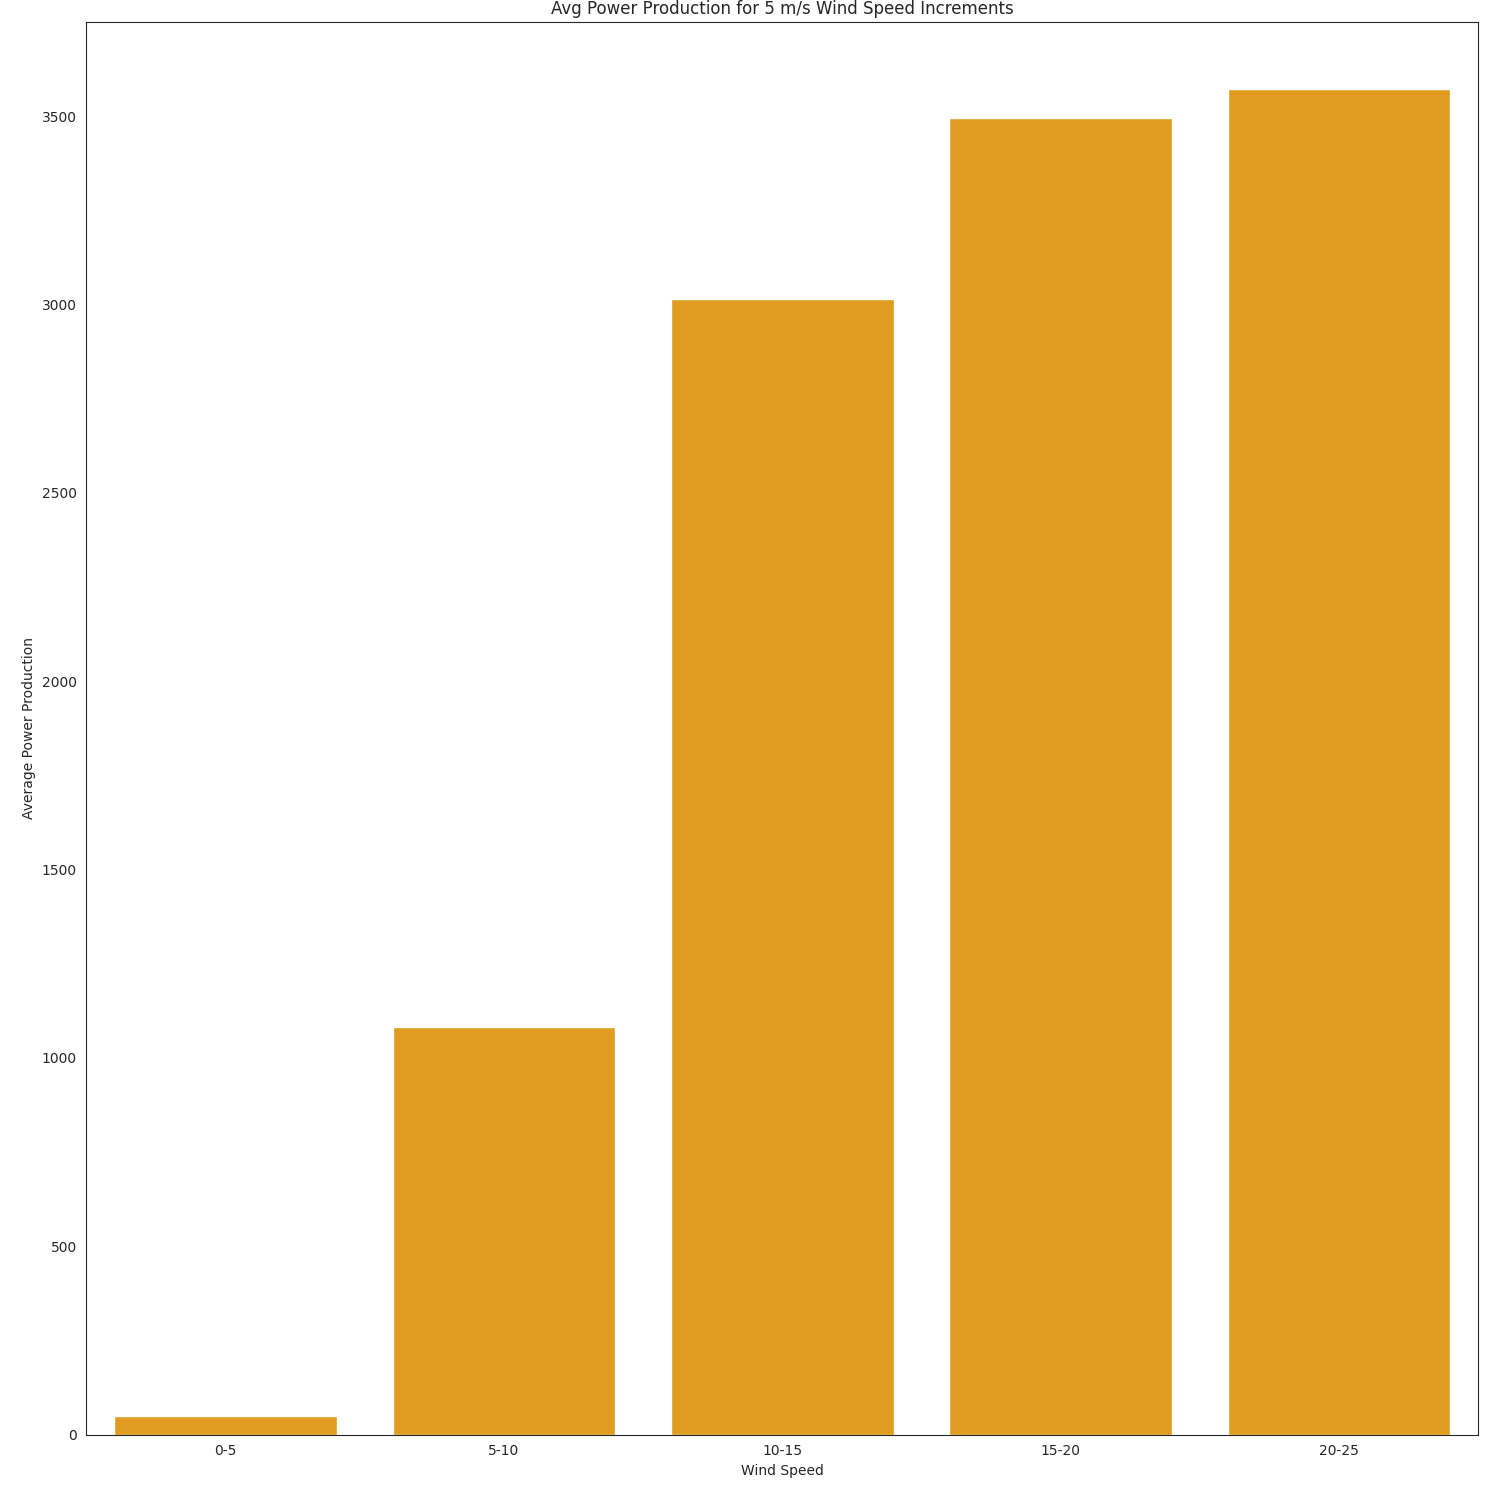

In [13]:
%%spark
# Finding average power production for 5 m/s wind speed increments
wind_speed = []
avg_power = []
for i in [0,5,10,15,20]:
    avg_value = spark_df.filter((spark_df['wind speed (m/s)'] > i) 
                                & (spark_df['wind speed (m/s)'] <= i+5))\
                                .agg({'lv activepower (kw)':'mean'}).collect()[0][0] 
    avg_power.append(avg_value)
    wind_speed.append(str(i) + '-' + str(i+5))

plt.clf()
sns.barplot(x=wind_speed, y=avg_power, color='orange')
plt.title('Avg Power Production for 5 m/s Wind Speed Increments')
plt.xlabel('Wind Speed')
plt.ylabel('Average Power Production');

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

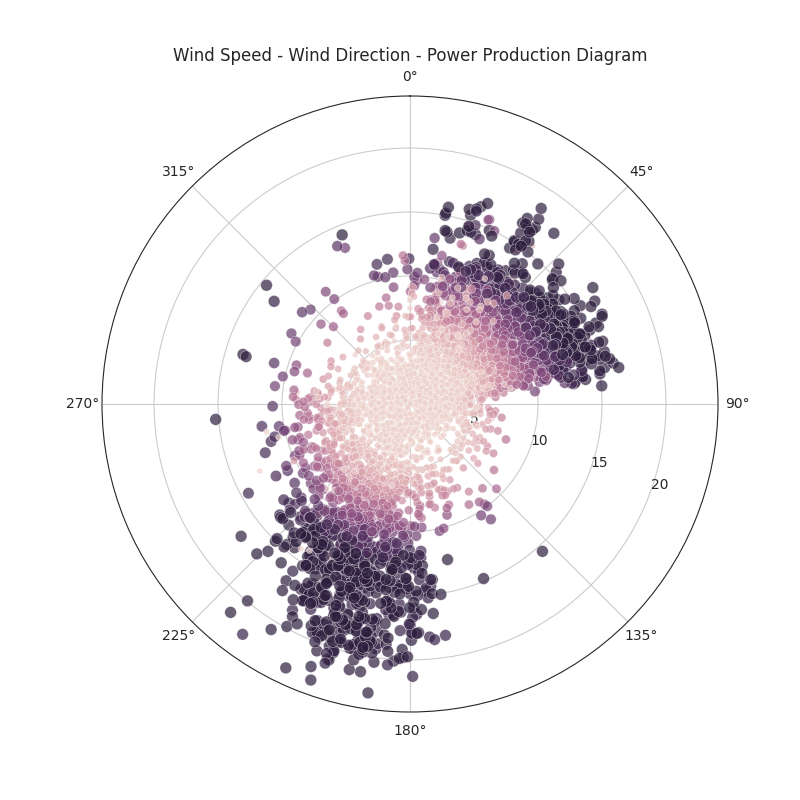

In [14]:
%%spark
# Creating the polar diagram
from math import radians

plt.clf()
plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
# Inside circles are the wind speed and marker color and size represents the amount of power production
sns.scatterplot(x=[radians(x) for x in sample_df['wind direction (deg)']], 
                y=sample_df['wind speed (m/s)'],
                size=sample_df['lv activepower (kw)'],
                hue=sample_df['lv activepower (kw)'],
                alpha=0.7, legend=None)
# Setting the polar diagram's top represents the North 
ax.set_theta_zero_location('N')
# Setting -1 to start the wind direction clockwise
ax.set_theta_direction(-1)
# Setting wind speed labels in a better position to see
ax.set_rlabel_position(110)
plt.title('Wind Speed - Wind Direction - Power Production Diagram')
plt.ylabel(None);

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

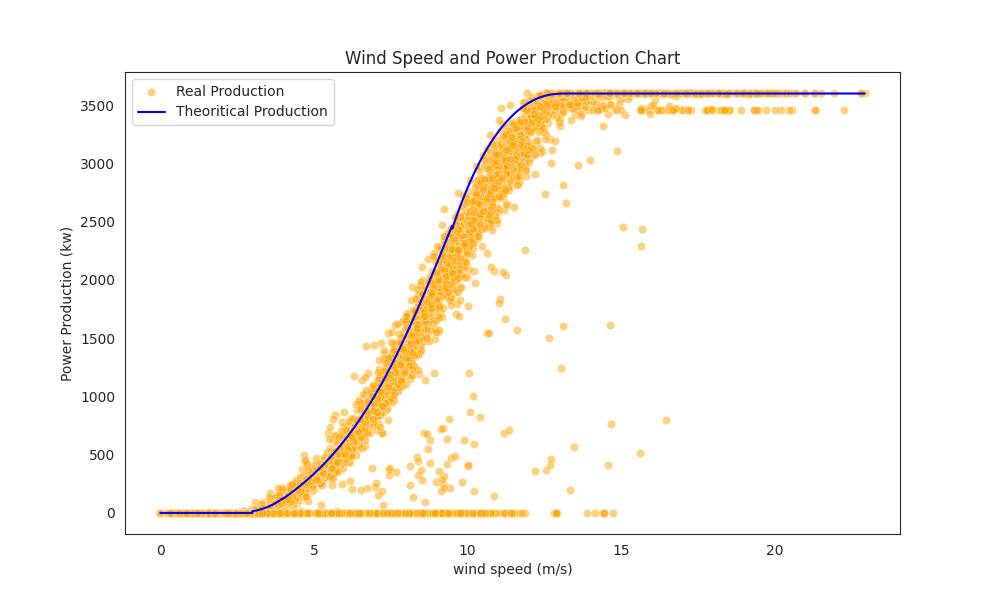

In [15]:
%%spark
plt.clf()
plt.figure(figsize=(10,6))
sns.scatterplot(x='wind speed (m/s)', y='lv activepower (kw)', color='orange', label='Real Production', alpha=0.5, data=sample_df)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', color='blue', label='Theoritical Production', data=sample_df)
plt.title('Wind Speed and Power Production Chart')
plt.ylabel('Power Production (kw)');

%matplot plt

In [16]:
%%spark
# Filter the big data where the real and theoritical power productions are equal to 0
zero_theo_power = spark_df.filter((spark_df['lv activepower (kw)'] == 0)
                                  & (spark_df['theoretical_power_curve (kwh)'] == 0)).toPandas()

print(zero_theo_power[['wind speed (m/s)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']].sample(5))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      wind speed (m/s)  theoretical_power_curve (kwh)  lv activepower (kw)
2836              0.58                           0.00                 0.00
6280              0.76                           0.00                 0.00
3481              1.76                           0.00                 0.00
4145              0.84                           0.00                 0.00
3992              2.14                           0.00                 0.00

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

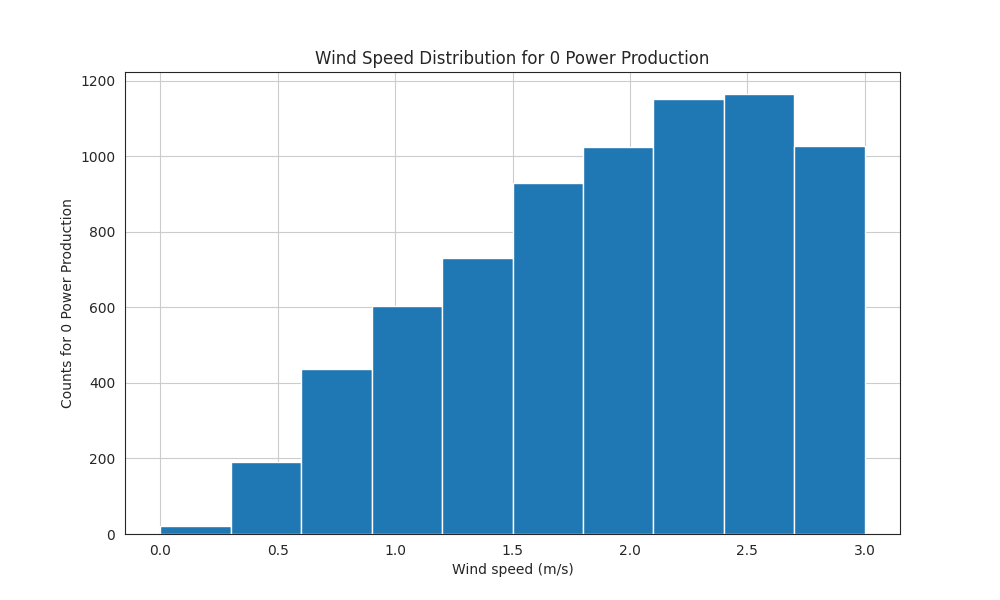

In [17]:
%%spark
plt.clf()
# Let's see the wind speed distribution for 0 power production
zero_theo_power['wind speed (m/s)'].hist()
plt.title('Wind Speed Distribution for 0 Power Production')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Counts for 0 Power Production');

%matplot plt

In [18]:
%%spark
# Observations for the wind speed > 3m/s and power production = 0, 
# While theoritically there should be power production
zero_power = spark_df.filter((spark_df['lv activepower (kw)'] == 0)
                            & (spark_df['theoretical_power_curve (kwh)'] != 0)
                            & (spark_df['wind speed (m/s)'] > 3)).toPandas()
print(zero_power.head())
print('No of Observations (while Wind Speed > 3 m/s and Power Production = 0): ', len(zero_power))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

          date/time  lv activepower (kw)  wind speed (m/s)  \
0  03 01 2018 15:40                 0.00              3.74   
1  03 01 2018 16:40                 0.00              3.03   
2  03 01 2018 16:50                 0.00              3.20   
3  03 01 2018 17:00                 0.00              3.91   
4  04 01 2018 13:50                 0.00              3.44   

   theoretical_power_curve (kwh)  wind direction (deg)  month  hour  
0                          83.99                245.07      1    15  
1                          17.18                221.09      1    16  
2                          25.43                232.68      1    16  
3                         110.98                241.97      1    17  
4                          45.74                 79.09      1    13  
No of Observations (while Wind Speed > 3 m/s and Power Production = 0):  3497

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

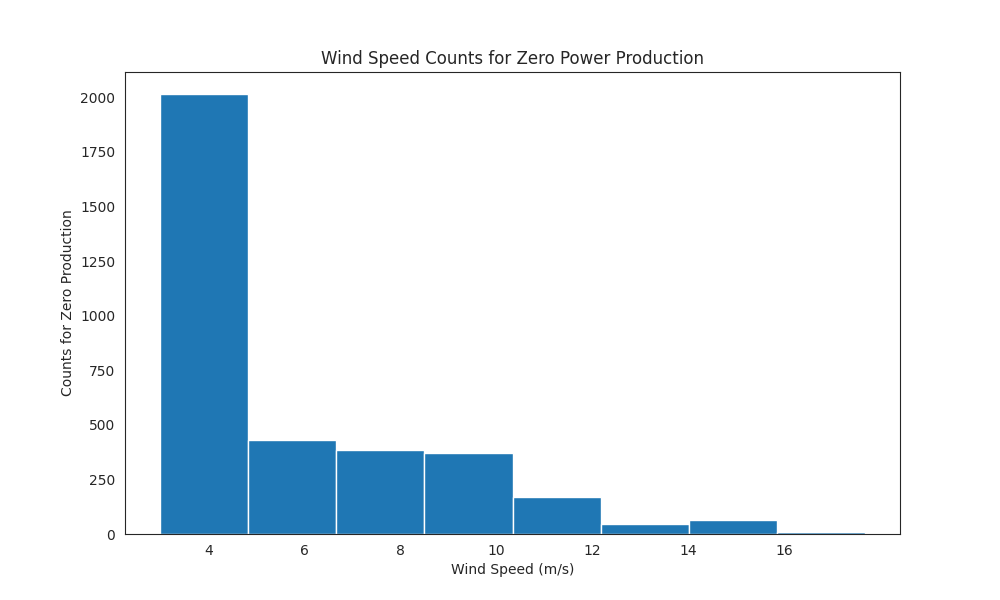

In [19]:
%%spark
plt.clf()
zero_power['wind speed (m/s)'].plot.hist(bins=8)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Counts for Zero Production')
plt.title('Wind Speed Counts for Zero Power Production')
plt.xticks(ticks=np.arange(4,18,2));

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

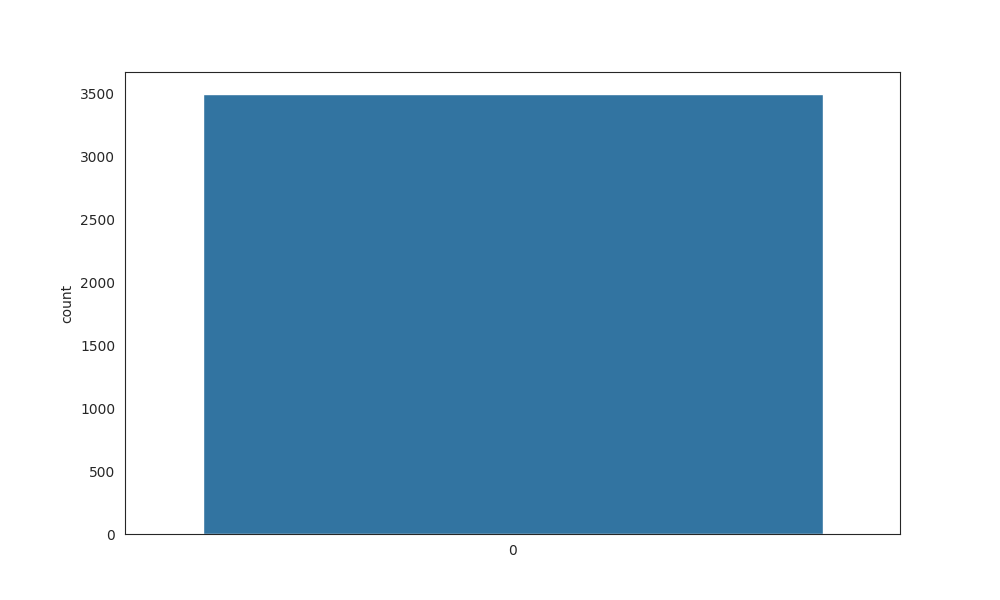

In [20]:
%%spark
plt.clf()
sns.countplot(zero_power['month']);
%matplot plt

In [21]:
%%spark
# Excluding the observations meeting the filter criterias 
spark_df = spark_df.filter(~((spark_df['lv activepower (kw)'] == 0)
                            & (spark_df['theoretical_power_curve (kwh)'] != 0)
                            & (spark_df['wind speed (m/s)'] > 3)))
spark_df.show(20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+-------------------+----------------+-----------------------------+--------------------+-----+----+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (deg)|month|hour|
+----------------+-------------------+----------------+-----------------------------+--------------------+-----+----+
|01 01 2018 00:00|        380.0477905|      5.31133604|                  416.3289078|         259.9949036|    1|   0|
|01 01 2018 00:10|        453.7691956|     5.672166824|                  519.9175111|         268.6411133|    1|   0|
|01 01 2018 00:20|        306.3765869|     5.216036797|                  390.9000158|         272.5647888|    1|   0|
|01 01 2018 00:30|        419.6459045|     5.659674168|                   516.127569|         271.2580872|    1|   0|
|01 01 2018 00:40|        380.6506958|     5.577940941|                   491.702972|         265.6742859|    1|   0|
|01 01 2018 00:50|        402.3919983|     5.604052067| 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

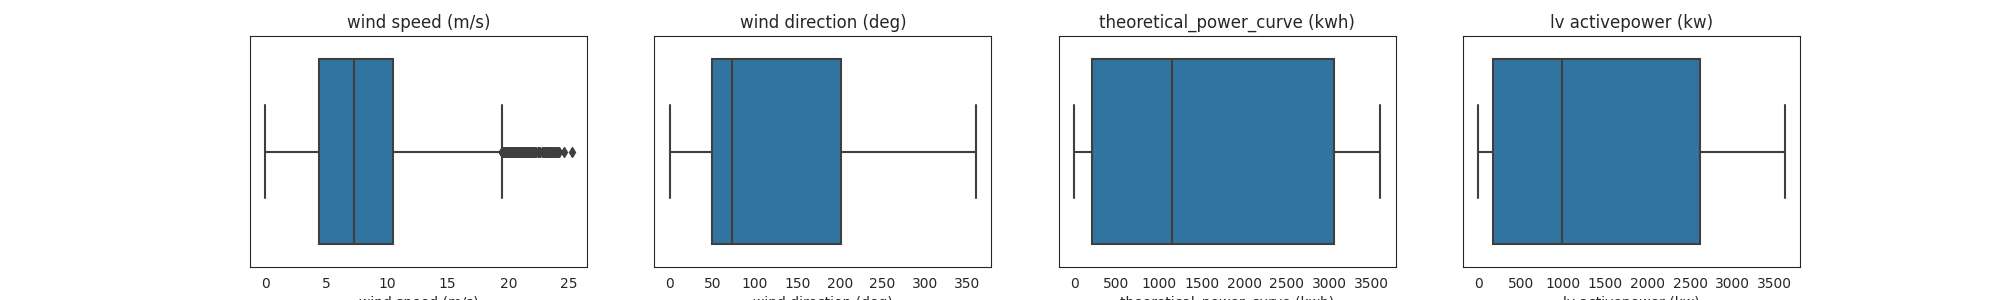

In [22]:
%%spark
columns = ['wind speed (m/s)', 'wind direction (deg)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']
i=1
plt.clf()
plt.figure(figsize=(20,3))
for each in columns:
    df = spark_df.select(each).toPandas()
    plt.subplot(1,4,i)
    #plt.boxplot(df)
    sns.boxplot(x=df[each])
    plt.title(each)
    i += 1
    
%matplot plt

In [23]:
%%spark
# Create a pandas df for visualization
wind_speed = spark_df.select('wind speed (m/s)').toPandas()

# Defining the quantiles and interquantile range
Q1 = wind_speed['wind speed (m/s)'].quantile(0.25)
Q3 = wind_speed['wind speed (m/s)'].quantile(0.75)
IQR = Q3-Q1
# Defining the lower and upper threshold values
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

print('Quantile (0.25): ', Q1, '  Quantile (0.75): ', Q3)
print('Lower threshold: ', lower, ' Upper threshold: ', upper)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Quantile (0.25):  4.455846786   Quantile (0.75):  10.47719002
Lower threshold:  -4.576168064999999  Upper threshold:  19.509204871

In [24]:
%%spark

# Fancy indexing for outliers
outlier_tf = (wind_speed['wind speed (m/s)'] < lower) | (wind_speed['wind speed (m/s)'] > upper)

print('Total Number of Outliers: ', len(wind_speed['wind speed (m/s)'][outlier_tf]))
print('--'*15)
print('Some Examples of Outliers:')
print(wind_speed['wind speed (m/s)'][outlier_tf].sample(10))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Number of Outliers:  407
------------------------------
Some Examples of Outliers:
8988    19.94
3558    22.98
7465    20.03
2421    19.92
7475    20.31
3270    21.27
3608    19.75
41665   19.70
3474    19.57
10872   20.34
Name: wind speed (m/s), dtype: float64

In [25]:
%%spark
spark_df.select('wind speed (m/s)', 'lv activepower (kw)')\
.filter(spark_df['wind speed (m/s)'] >= 19)\
.agg({'lv activepower (kw)':'mean'}).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      3566.4634427902906|
+------------------------+

In [26]:
%%spark
from pyspark.sql import functions as F
spark_df = spark_df.withColumn('wind speed (m/s)', 
                               F.when(F.col('wind speed (m/s)') > 19.447, 19)
                               .otherwise(F.col('wind speed (m/s)')))
spark_df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

47033

In [27]:
%%spark
# High level power production
spark_df.filter(((spark_df['month'] == 3) | (spark_df['month'] == 8) | (spark_df['month'] == 11)) 
                & ((spark_df['hour'] >= 16) | (spark_df['hour'] <= 24)) 
                & ((spark_df['wind direction (deg)'] > 0) | (spark_df['wind direction (deg)'] < 90))
                & ((spark_df['wind direction (deg)'] > 180) | (spark_df['wind direction (deg)'] < 225))
               ).agg({'lv activepower (kw)':'mean'}).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      2013.4446757911744|
+------------------------+

In [28]:
%%spark
# Low level power production
spark_df.filter((spark_df['month'] == 7) 
                & ((spark_df['hour'] >= 9) | (spark_df['hour'] <= 11)) 
                & ((spark_df['wind direction (deg)'] > 90) | (spark_df['wind direction (deg)'] < 160))
               ).agg({'lv activepower (kw)':'mean'}).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      503.16442054071854|
+------------------------+

In [29]:
%%spark
# Preparing the independent variables (Features)
from pyspark.ml.feature import VectorAssembler

# Converting lv activepower (kw) variable as label
spark_df = spark_df.withColumn('label', spark_df['lv activepower (kw)'])

# Defining the variables to be used
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (deg)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
va_df = vectorAssembler.transform(spark_df)

# Combining features and label column
final_df = va_df.select('features', 'label')
final_df.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------+
|            features|      label|
+--------------------+-----------+
|[1.0,0.0,5.311336...|380.0477905|
|[1.0,0.0,5.672166...|453.7691956|
|[1.0,0.0,5.216036...|306.3765869|
|[1.0,0.0,5.659674...|419.6459045|
|[1.0,0.0,5.577940...|380.6506958|
|[1.0,0.0,5.604052...|402.3919983|
|[1.0,1.0,5.793007...|447.6057129|
|[1.0,1.0,5.306049...|387.2421875|
|[1.0,1.0,5.584629...|463.6512146|
|[1.0,1.0,5.523228...| 439.725708|
+--------------------+-----------+
only showing top 10 rows

In [30]:
%%spark
splits = final_df.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

print('Train dataset: ', train_df.count())
print('Test dataset : ', test_df.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Train dataset:  37641
Test dataset :  9392

In [31]:
%%spark
from pyspark.ml.regression import GBTRegressor

# Creating the gbm regressor object
gbm = GBTRegressor(featuresCol='features', labelCol='label')

# Training the model with train data
gbm_model = gbm.fit(train_df)

# Predicting using the test data
y_pred = gbm_model.transform(test_df)

# Initial look at the target and predicted values
y_pred.select('label', 'prediction').show(20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+------------------+
|      label|        prediction|
+-----------+------------------+
|        0.0| 21.29680397129343|
|22.84959984|37.457227914907946|
|346.6856995|326.06962382974075|
|380.6506958|504.46190718581954|
|419.6459045|504.46190718581954|
|453.7691956|504.46190718581954|
|875.7213135| 752.9848855044835|
|750.5510254| 741.3424721280371|
| 1045.36499|1002.8776535120204|
|874.7224731|1017.1677093371283|
|1182.035034|1158.4114338002878|
|1724.671997|1683.0686209228609|
|2169.958984|1961.2734467453222|
|2044.208008| 1912.728208148241|
|2455.433105|2319.8179750767154|
|2947.684082|2957.9091162586756|
| 3412.39209|3324.2540282146006|
|1331.803955|3324.2540282146006|
|3603.468994|3324.2540282146006|
|3538.520996|3511.8179784531853|
+-----------+------------------+
only showing top 20 rows

In [34]:
%%spark
gbm_model.write().overwrite().save("file:///mounts/shared-volume/user/spark/GBM.model")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
%%spark
from pyspark.ml.regression import GBTRegressionModel
gbm_model_dtap = GBTRegressionModel.load("file:///mounts/shared-volume/user/spark/GBM.model")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

AttributeError: Cannot load _jvm from SparkContext. Is SparkContext initialized?

In [ ]:
%%spark
# Initial model success
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

print('R2 SCORE : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'}))
print('MAE      : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'mae'}))
print('RMSE     : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'}))

In [ ]:
%%spark
# Converting sample_df back to Spark dataframe
eva_df = spark.createDataFrame(sample_df)

# Converting lv activepower (kw) variable as label
eva_df = eva_df.withColumn('label', eva_df['lv activepower (kw)'])

# Defining the variables to be used
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (deg)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
vec_df = vectorAssembler.transform(eva_df)

# Combining features and label column
vec_df = vec_df.select('features', 'label')

# Using ML model to predict
preds = gbm_model.transform(vec_df)
preds_df = preds.select('label','prediction').toPandas()

# Compining dataframes to compare
frames = [sample_df[['wind speed (m/s)', 'theoretical_power_curve (kwh)']], preds_df]
sample_data = pd.concat(frames, axis=1)

plt.clf()
# Visualizing real, theoritical and predicted power production
plt.figure(figsize=(10,7))
sns.scatterplot(x='wind speed (m/s)', y='label',alpha=0.5, label= 'Real Power', data=sample_data)
sns.scatterplot(x='wind speed (m/s)', y='prediction', alpha=0.7, label='Predicted Power', marker='o', data=sample_data)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', label='Theoritical Power',color='purple', data=sample_data)
plt.title('Wind Turbine Power Production Prediction')
plt.ylabel('Power Production (kw)')
plt.legend();

%matplot plt